# Algorithms for Big Data - Exercise 7
This lecture is focused on the more advanced examples of the RNN usage for text generation.

We will use Harry Potter books in this lectures for generating our own stories.

You can download the dataset from this course [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)


[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_08.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_08.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

In [3]:
import requests
from typing import List, Tuple

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/fei/svo0175/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# We need to download the data first and split text to lines

In [6]:
req = requests.get('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/hp1.txt', allow_redirects=True)

In [7]:
txt = str(req.text).splitlines()

In [8]:
txt[:20]

["Harry Potter and the Sorcerer's Stone",
 '',
 '',
 'CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did',
 'have a very large mustache. Mrs. Dursley was thin and blonde and had',
 'nearly twice the usual amount of neck, which came in very useful as she',
 'spent so much of her time craning over garden fences, spying on the',
 'neighbors. The Dursleys had a small son called Dudley and in their',
 'opinion there was no finer boy anywhere.',
 '']

## We can see that the text is far from perfect because we have some noise in the data as in the last lecture
We need to preprocess the text to be suitable for the RNN application. We need to clear blank lines and remove chapter headers. To simplify the task, we will get rid partialy of the interpunction as well for now. Final step will be joining the text into one big string.

In [9]:
txt = txt[3:]
txt[:10]

['CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made']

#### Remove the chapter header with chapter name
We will remove the blank lines in this part as well.

In [10]:
txt = [x for x in txt if 'CHAPTER ' not in x]
txt[:10]

['',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did']

In [11]:
txt = [x for x in txt if not x.upper() == x]
txt[:10]

['Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did',
 'have a very large mustache. Mrs. Dursley was thin and blonde and had',
 'nearly twice the usual amount of neck, which came in very useful as she',
 'spent so much of her time craning over garden fences, spying on the',
 'neighbors. The Dursleys had a small son called Dudley and in their']

### There are another minor imperfections connected to the  -- 't -- suffix, we need to fix it.

In [12]:
[x for x in txt if "\'" in x][25:30]

['a squeaky voice that made passersby stare, "Don\'t be sorry, my dear sir,',
 "didn't approve of imagination.",
 "and it didn't improve his mood -- was the tabby cat he'd spotted that",
 '"Shoo!" said Mr. Dursley loudly. The cat didn\'t move. It just gave him a',
 "about Mrs. Next Door's problems with her daughter and how Dudley had"]

In [13]:
txt = [x.replace('"', '') for x in txt]
[x for x in txt if "a squeaky voice that" in x]

["a squeaky voice that made passersby stare, Don't be sorry, my dear sir,"]

### We will join the text to one long line and tokenize it like the last time

In [14]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

def fix_s(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "'s":
            st_res.append(words[i]+("'s"))
        else:
            if words[i] != "'s":
                st_res.append(words[i])
    return st_res

def normalize(words):
    words = remove_non_ascii(words)
    words = fix_nt(words)   
    words = fix_s(words)
    return words



In [15]:
txt_one_line = ' '.join(txt)

In [16]:
txt_one_line[:300]

"Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr. Dursley was the director of a fir"

In [17]:
tokenized = TextBlob(txt_one_line).words

In [18]:
tokenized = normalize(tokenized)

### n't suffix should be fixed now (far from ideal TextBlob functionality)

In [19]:
[x for x in tokenized if "'s" in x or "n't" in x][:10]

["didn't",
 "didn't",
 "Dursley's",
 "hadn't",
 "didn't",
 "didn't",
 "four's",
 "didn't",
 "wasn't",
 "couldn't"]

### Final step of the preprocessing is joining the tokenized text back into fixed length sequences

### We differ among 4 modes of predictions in case of RNN
 - 1:1 - One word is classified as one of the classes, e.g. POS tag
 - 1:N - One word is classified in multiple classes, not very common
 - N:1 - Very commom, e.g. sentiment analysis
 - N:N - Also very common, e.g. machine translation, text generation
 
![rnn_pred](https://github.com/rasvob/2020-21-ARD/raw/master/images/rnn_pred.jpeg)
 
We need to define training vectors which are of the same length. There are multiple approaches for text generation - N:1 or N:N. The problem of the N:N approach is that it will generate fixed length sequences. Thus it's wise to transform the task into N:1 classification task, with N words in the training vector. Network will predict the next word for the input sequence which is basicaly a classification task.

#### Sequence length is very important hyper-parameter!!


# Let's take a look at the vocabulary size

In [20]:
dist = nltk.FreqDist(tokenized)

### We have 6829 unique words

In [21]:
len(dist)

6829

In [22]:
most_common_words = sorted(list(dist.items()), key=lambda x: x[1], reverse=True)[:30]

<AxesSubplot:>

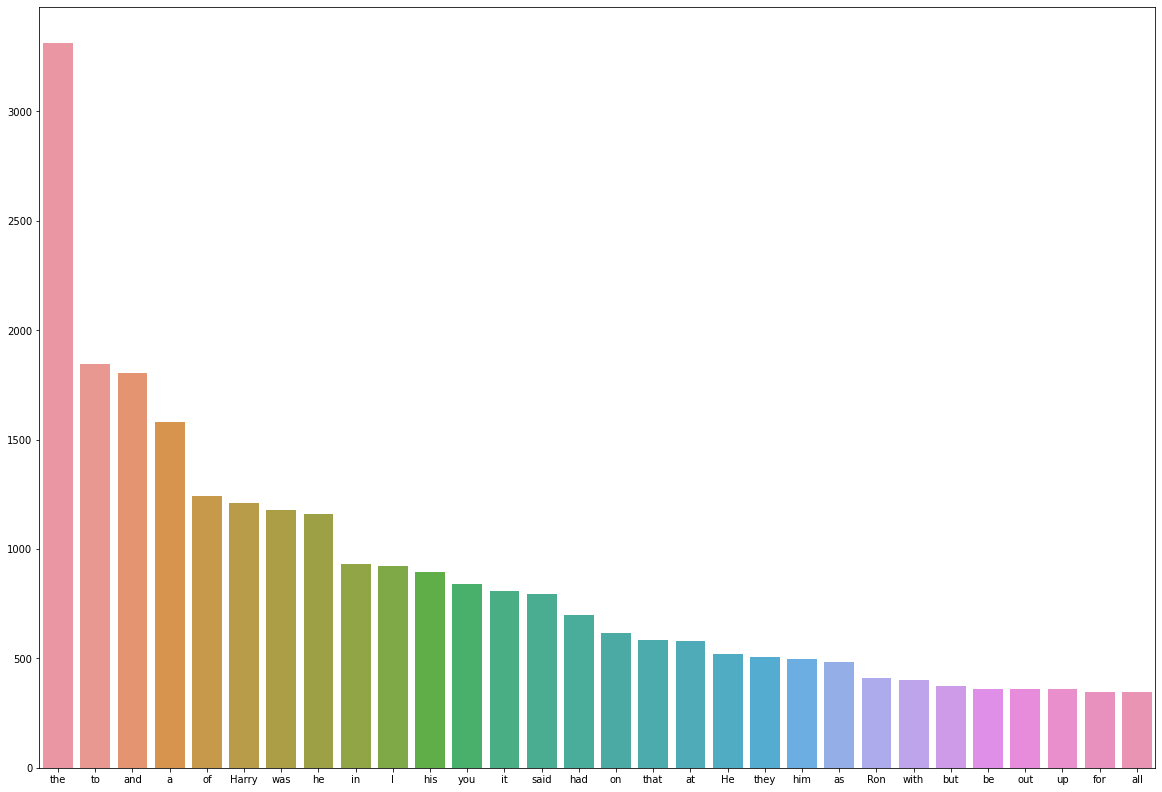

In [23]:
ax, fig = plt.subplots(1, figsize=(20, 14))
sns.barplot(x=[x[0] for x in most_common_words], y=[x[1] for x in most_common_words])

## We have 78301 words in the whole corpus

In [24]:
len(tokenized)

78301

In [25]:
def create_vectors(tokens, sequence_length:int) -> Tuple[List, str]:
    X, y = [], []
    
    for i in range(0, len(tokens) - sequence_length - 1):
        seq, word = tokens[i:i+sequence_length], tokens[i + sequence_length]
        X.append(' '.join(seq))
        y.append(word)
        
    return X, y

In [26]:
SEQ_LEN = 20

In [27]:
X, y = create_vectors(tokenized, SEQ_LEN)

In [28]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [29]:
X[1]

'and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very'

In [30]:
y[0]

'very'

In [31]:
len(X)

78280

In [32]:
from tensorflow import string as tf_string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [33]:
embedding_dim = 50 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 7000 # Number of unique tokens in vocabulary
sequence_length = SEQ_LEN # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(standardize=None, max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X)

# Final step is integer encoding of the target words into numbers according to the defined vocabulary

In [34]:
vect_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'Harry', 'was', 'he']

In [35]:
vocab = vect_layer.get_vocabulary()

In [36]:
dict_vocab = {vocab[i]: i  for i in range(len(vocab))}

In [37]:
len(vect_layer.get_vocabulary())

6831

In [38]:
vocabulary_size = len(vect_layer.get_vocabulary())

In [39]:
y_enc = [dict_vocab[x] for x in y]

In [40]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_enc, test_size=0.2, random_state=13)

# We can define our model and train it using created sequences

In [42]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = CuDNNLSTM(512, return_sequences=True)(emb)
x = CuDNNLSTM(256, return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(vocabulary_size, activation=tf.nn.softmax)(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 50)            350000    
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 20, 512)           1155072   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               788480    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [43]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)

batch_size = 128
epochs = 5
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/5
490/490 [==============================] - 21s 43ms/step - loss: 6.8678 - accuracy: 0.0418 - val_loss: 6.7267 - val_accuracy: 0.0457
Epoch 2/5
490/490 [==============================] - 9s 19ms/step - loss: 6.5811 - accuracy: 0.0479 - val_loss: 6.6457 - val_accuracy: 0.0484
Epoch 3/5
490/490 [==============================] - 9s 19ms/step - loss: 6.4203 - accuracy: 0.0521 - val_loss: 6.5002 - val_accuracy: 0.0563
Epoch 4/5
490/490 [==============================] - 9s 19ms/step - loss: 6.3108 - accuracy: 0.0607 - val_loss: 6.4095 - val_accuracy: 0.0644
Epoch 5/5
490/490 [==============================] - 9s 19ms/step - loss: 6.2292 - accuracy: 0.0682 - val_loss: 6.3457 - val_accuracy: 0.0710


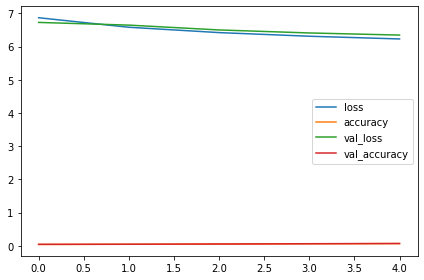

In [44]:
show_history(history)

In [45]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [46]:
y_pred = model.predict([X[0]])

## Softmax gives you the probabilities which sums to 1 for every word in vocabulary
We need to to choose the word with the highest probability.

In [47]:
y_pred

array([[4.5709744e-06, 4.7308745e-06, 1.1435322e-02, ..., 6.3204270e-06,
        4.6353821e-06, 7.5685662e-06]], dtype=float32)

In [48]:
y_pred = np.argmax(y_pred[0])

In [49]:
y_pred

8

In [50]:
vocab[y_pred]

'was'

#### We won't use probabilities directly but we will sample from the predicted outputs using Temperature Softmax [see this](https://medium.com/@majid.ghafouri/why-should-we-use-temperature-in-softmax-3709f4e0161)

Basically, its ideas is that it would re-weight the probability distribution so that you can control how much surprising (i.e. higher temperature/entropy) or predictable (i.e. lower temperature/entropy) the next selected character would be.

In [51]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

We have to first generate a 20 vocab long sentence called seed text, then our model will use seed text to predict the next vocab, then we update the seed text with our newly generated vocab to predict the next vocab. Repeat this process to generate new text content.

In [52]:
paragraph = X[0]
whole_text = paragraph
for i in range(50):
    y_pred = model.predict([paragraph])
    y_pred = sample(y_pred[0], 10)
    word = vocab[y_pred]
    paragraph += f' {word}'
    whole_text += f' {word}'
    tokens = paragraph.split()
    paragraph = ' '.join(tokens[-SEQ_LEN:])

In [53]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [54]:
whole_text

"Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you kill do Owls Whether boastful Zabini slimy clearly Shouldn'ta instantly boat enjoy Bonfire breaking hawk servant flattering expression locker sp utter Miss lean Thinking Neck rows Young opposite awake scrawl rocket forecast stuck pile Smiling Headmistress impressively sucked duster he's unwrap Useful wasn't threshold Going Blacks surrounded nosie Term troll's"

# We can even use pre-trained embedding

# We need to download the embedding files
~~~
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
~~~

50 dims GLOVE is also avaiable here: https://vsb.ai/vsbai/static/data/glove.6B.50d.txt

# First we need to load the file to memory and create embedding dictionary

In [55]:
path_to_glove_file = './data/glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## We need to get the voacabulary from the Vectorizer and the integer indexes

In [56]:
embedding_dim = 50 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 7000 # Number of unique tokens in vocabulary
sequence_length = SEQ_LEN # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(standardize=None, max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X)

In [57]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [58]:
len(voc)

6831

In [59]:
voc[:10]

['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'Harry', 'was', 'he']

In [60]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5154 words (1677 misses)


In [61]:
show_historyyer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)
x = CuDNNLSTM(128, return_sequences=True)(emb)
x = CuDNNLSTM(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
output_layer = keras.layers.Dense(vocabulary_size, activation=tf.nn.softmax)(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 50)            341650    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20, 128)           92160     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20, 128)           132096    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

#### Let's try to train the model for much longer time

In [62]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)

batch_size = 128
# epochs = 50
epochs = 5

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es], epochs=epochs, batch_size=batch_size)

Epoch 1/5
490/490 [==============================] - 14s 29ms/step - loss: 6.9847 - accuracy: 0.0399 - val_loss: 6.7715 - val_accuracy: 0.0416
Epoch 2/5
490/490 [==============================] - 7s 14ms/step - loss: 6.7180 - accuracy: 0.0424 - val_loss: 6.7566 - val_accuracy: 0.0416
Epoch 3/5
490/490 [==============================] - 7s 14ms/step - loss: 6.6324 - accuracy: 0.0427 - val_loss: 6.7055 - val_accuracy: 0.0429
Epoch 4/5
490/490 [==============================] - 7s 14ms/step - loss: 6.5430 - accuracy: 0.0455 - val_loss: 6.6783 - val_accuracy: 0.0491
Epoch 5/5
490/490 [==============================] - 7s 14ms/step - loss: 6.4492 - accuracy: 0.0507 - val_loss: 6.6194 - val_accuracy: 0.0618


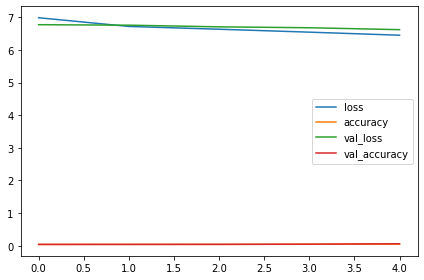

In [63]:
show_history(history)

In [64]:
paragraph = X[0]
whole_text = paragraph
for i in range(50):
    y_pred = model.predict([paragraph])
    y_pred = sample(y_pred[0], 1)
    word = vocab[y_pred]
    paragraph += f' {word}'
    whole_text += f' {word}'
    tokens = paragraph.split()
    paragraph = ' '.join(tokens[-SEQ_LEN:])

In [65]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [66]:
whole_text

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you could noticed a spiral into up the way and one felt McGonagall are go Aunt jokes years that books really strode like door Be eyes straight Hagrid it us Mrs banner looked every as me pulled we Look red even from did being reptile dad The offered as I stairs'

# Your can see that we are able to generate text of any length using this approach, unfortunately the task is quite complex for model of this simplicity and relatively small dataset
## The text usually doesn't make much sense as you could see

# Another approach is to create character-level model which learns how to write from scratch
## We will try to train this model and comprare obtained results

#### We will simplify the task for using only lower case letters

In [67]:
txt_one_line = txt_one_line.lower()

In [68]:
txt_one_line[:100]

'mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly norma'

# Task for the lecture
 - Choose either word or character level model
 - Choose another, at least one, HP book (it's on my Github, link at the top)
 - Preprocess it according to the first one
 - Merge the books together
 - Use pre-defined model from lecture or your own and train it for the long time (epochs > 50)
 - Experiment a little - try different batch sizes, optimimizers
 - Send me the Colab notebook with results and description of what you did and your final solution!